In [1]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/rdflib_jsonld/__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/home/trosnet/.wdm/drivers/chromedriver/linux64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [3]:
TIMEOUT = (10, 300)
NB = 500
OUTPUT_DIR = "./results/dryad_data/"

def dryadRequest(url):
    print("REST request to dryad...")
    # rest request
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except requests.exceptions.SSLError:
            print("Error, retrying...")
            time.sleep(5)
        except requests.exceptions.Timeout:
            print("Timeout error, retrying...")
            time.sleep(5)

    return response

# def dryadResponseToXML(response):
#     print("Parsing result...")
#     while True:
#         try:
#             parser = ET.XMLParser(encoding="utf-8")
#             # xml result
#             xml_root = ET.fromstring(response, parser=parser)
#             break
#         except ET.ParseError as e:
#             print(e)
#             time.sleep(10)

#     return xml_root

# def dryadXMLParser(xml_root):
#     dois_list = []

#     for object_info in xml_root.iter('objectInfo'):
#         for identifier in object_info.findall('identifier'):
#             dois_list.append(identifier.text.split('?')[0])
#     dois_list = list(set(dois_list))
#     return dois_list

def dryadParser(response):
    print("Parsing result...")
    json_response = response.json()
    next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
    count_step = int(json_response["count"])
    print(next_page)

    
    dois_list = []
    count = 0
    while True:
        for element in json_response["_embedded"]["stash:datasets"]:
            identifier = element["identifier"].replace("doi:", "https://doi.org/")
            dois_list.append(identifier)

        count += count_step
        if count > NB:
            break
        response = dryadRequest(next_page)
        json_response = response.json()
        next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
        print(next_page)
        

    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list
    

In [4]:
response = dryadRequest("https://datadryad.org/api/v2/datasets?per_page=100")
# xml_root = dryadResponseToXML(response)
dois_list = dryadParser(response)
print(len(dois_list))

REST request to dryad...
Parsing result...
https://datadryad.org/api/v2/datasets?page=2&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=3&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=4&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=5&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=6&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=7&per_page=100
Retrieved 600 DOIs
600


In [5]:
import random
#sample_tool = random.choice(index.keys())

random.seed(10)

#samples = random.sample(list(index.items()), 1000)
samples_dois_list = random.sample(dois_list, 500)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))
print(samples_dois_list)

500
['https://doi.org/10.5061/dryad.v72m2', 'https://doi.org/10.5061/dryad.rh07b', 'https://doi.org/10.5061/dryad.tp097', 'https://doi.org/10.5061/dryad.hr0qt', 'https://doi.org/10.5061/dryad.mn46cd6', 'https://doi.org/10.5061/dryad.5bk4c', 'https://doi.org/10.5061/dryad.9tt2t', 'https://doi.org/10.5061/dryad.ns135', 'https://doi.org/10.5061/dryad.pm3g4r3', 'https://doi.org/10.5061/dryad.9pg8d', 'https://doi.org/10.5061/dryad.255hj', 'https://doi.org/10.5061/dryad.216tp', 'https://doi.org/10.5061/dryad.160mp', 'https://doi.org/10.5061/dryad.1n542', 'https://doi.org/10.5061/dryad.t6096', 'https://doi.org/10.5061/dryad.2k6v37j', 'https://doi.org/10.5061/dryad.qp50f', 'https://doi.org/10.5061/dryad.s57d6', 'https://doi.org/10.5061/dryad.c5p1f', 'https://doi.org/10.5061/dryad.2k6nr', 'https://doi.org/10.5061/dryad.jd5716f', 'https://doi.org/10.5061/dryad.hf46s', 'https://doi.org/10.5061/dryad.34s86', 'https://doi.org/10.5061/dryad.fb240', 'https://doi.org/10.5061/dryad.4r4j835', 'https://d

In [7]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
# metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [8]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
#     metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time


In [9]:
#%%time

def mass_eval(samples):
    evals = []
    exec_time = []


    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [10]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_DRYAD_data_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_DRYAD_data_"+str(i)+".csv")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://sch

  0%|          | 0/100 [00:00<?, ?it/s]

http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://sch

  0%|          | 0/100 [00:00<?, ?it/s]

http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://sch

  0%|          | 0/100 [00:00<?, ?it/s]

http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://sch

  0%|          | 0/100 [00:00<?, ?it/s]

http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://schema.org
http://sch

In [11]:
len(df)

100

In [12]:
df_time

,ID,F1A,F1B,F2A,I1,I3,R1.1,R1.2
0,https://doi.org/10.5061/dryad.fq7gv88,0.0,0.01,0.0,0.0,0.01,0.02,0.02
1,https://doi.org/10.5061/dryad.j6823nt,0.0,0.01,0.0,0.0,0.00,0.01,0.01
2,https://doi.org/10.5061/dryad.620cq,0.0,0.01,0.0,0.0,0.00,0.01,0.01
3,https://doi.org/10.5061/dryad.gj3vj,0.0,0.01,0.0,0.0,0.00,0.01,0.01
4,https://doi.org/10.5061/dryad.8qp4n,0.0,0.01,0.0,0.0,0.00,0.01,0.01
...,...,...,...,...,...,...,...,...
95,https://doi.org/10.5061/dryad.8467g,0.0,0.01,0.0,0.0,0.00,0.01,0.01
96,https://doi.org/10.5061/dryad.d3j00,0.0,0.01,0.0,0.0,0.00,0.01,0.01
97,https://doi.org/10.5061/dryad.68n87,0.0,0.01,0.0,0.0,0.00,0.01,0.02
98,https://doi.org/10.5061/dryad.0318j,0.0,0.01,0.0,0.0,0.00,0.01,0.01


In [13]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_DRYAD_data_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [15]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
#F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]
# I1B = df[((df["I1B"].astype(int) > 0))]["ID"]

# I2 = df[((df["I2"].astype(int) > 0))]["ID"]
# I2B = df[((df["I2B"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
#R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
#                          'F2B*': F2B,
                          'I1': I1, 
#                           'I1B': I1B,
#                           'I2': I2, 
#                           'I2B': I2B,
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
#                          'R13*': R13})
df_upset

id
F1B  F2A  I1   I3   R11  R12                                          
True True True True True False     https://doi.org/10.5061/dryad.8n8v3
                         False     https://doi.org/10.5061/dryad.r20t0
                         False  https://doi.org/10.5061/dryad.q0740kp8
                         False     https://doi.org/10.5061/dryad.4384p
                         False     https://doi.org/10.5061/dryad.dh88c
...                                                                ...
                         False     https://doi.org/10.5061/dryad.8467g
                         False     https://doi.org/10.5061/dryad.d3j00
                         False     https://doi.org/10.5061/dryad.68n87
                         False     https://doi.org/10.5061/dryad.0318j
                         False   https://doi.org/10.5061/dryad.3fm645g

[500 rows x 1 columns]

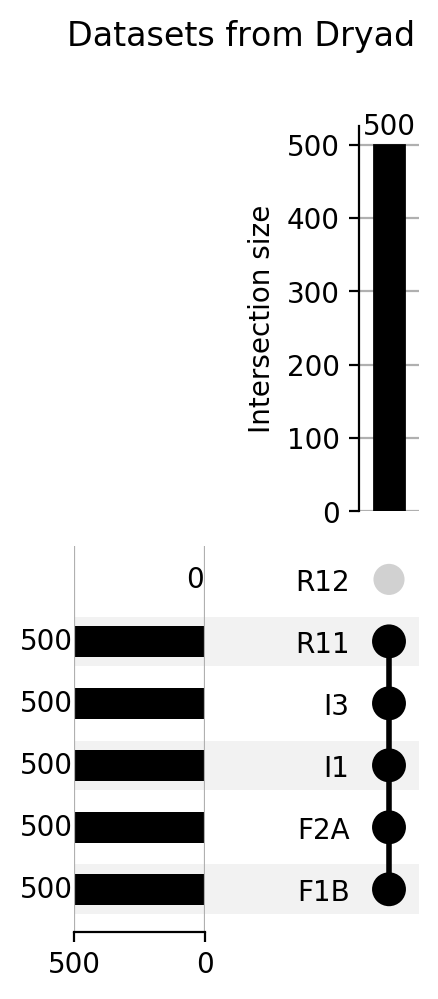

In [19]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Dryad")
plt.savefig(OUTPUT_DIR + 'DRYAD-no-F2B-no-R13_data.png', format="png")
plt.show()